In [1]:
import duckdb
import pandas as pd
import lightgbm as lgb

In [2]:
# Connect to an in-memory DuckDB database
conn = duckdb.connect()

In [4]:
df_sell_in = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/sell-in.txt')").to_df()
df_productos = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/tb_productos.txt')").to_df()
df_stocks = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/tb_stocks.txt')").to_df()
df_to_predict = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/product_id_to_predict_201912.txt')").to_df()

conn.register('sell_in', df_sell_in)
conn.register('products', df_productos)
conn.register('stocks', df_stocks)
conn.register('to_predict', df_to_predict)

In [5]:
# Print the df heads
print("df_sell_in")
df_sell_in

df_sell_in


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201803,10025,20097,0,1,0.30671,0.30671
1,201803,10241,20097,0,2,0.34853,0.34853
2,201803,10276,20109,0,1,0.13941,0.13941
3,201803,10298,20109,0,1,0.06971,0.06971
4,201803,10056,20109,0,1,1.53353,1.53353
...,...,...,...,...,...,...,...
2945813,201909,10170,20047,0,1,1.68015,1.68015
2945814,201909,10115,20075,0,1,0.28003,0.28003
2945815,201909,10076,20075,0,1,0.18202,0.18202
2945816,201909,10343,20075,0,1,0.14001,0.14001


In [6]:
print("df_productos")
df_productos

df_productos


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Mayonesa,NATURA,500,20547,Ketchup Vegano
1,FOODS,ADEREZOS,Mostaza,MOSTAZA1,180,21146,colchon de finas hierbas
2,FOODS,OTROS,Bizcochuelo,HARINAMA,500,20835,Naranja
3,FOODS,OTROS,Granolas,HARINAMA,35,21206,Sabor 4
4,FOODS,SOPAS Y CALDOS,Baking Bags,MAGGI,15,21143,Sabor 7
...,...,...,...,...,...,...,...
1246,PC,PIEL1,Cara,LANCOME,100,20882,Crema pepino
1247,PC,PIEL1,Cara,LANCOME,30,21140,Piel Sensible
1248,PC,PIEL2,Jabon Barra,SHAMPOO2,125,20431,Coco
1249,PC,PIEL2,LIQUIDOS,ESPADOL,250,20994,Jabon Antibacterial Liquido


In [7]:
df_productos.isna().sum()

cat1           0
cat2           0
cat3           0
brand          0
sku_size       0
product_id     0
descripcion    0
dtype: int64

In [8]:
print("df_stocks")
df_stocks

df_stocks


,periodo,product_id,stock_final
0,201810,20948,2.46997
1,201810,20033,201.94629
2,201810,20486,9.72972
3,201810,20472,57.04608
4,201810,20308,21.82639
...,...,...,...
13686,201912,20669,3.32964
13687,201912,21264,0.09653
13688,201912,20567,6.52317
13689,201912,20409,9.13185


In [9]:
print("df_to_predict")
df_to_predict

df_to_predict


,product_id
0,20001
1,20008
2,20009
3,20013
4,20031
...,...
775,21044
776,21055
777,21065
778,21119


In [10]:
productos_ventas = set(df_sell_in['product_id'].unique())
productos_maestro = set(df_productos['product_id'].unique())

faltantes_en_productos = productos_ventas - productos_maestro
print(f"🛑 Productos en df_sell_in pero NO en df_productos: {len(faltantes_en_productos)}")
print(faltantes_en_productos)

🛑 Productos en df_sell_in pero NO en df_productos: 45
{np.int64(21249), np.int64(21125), np.int64(21253), np.int64(21268), np.int64(21270), np.int64(21272), np.int64(21273), np.int64(21274), np.int64(21275), np.int64(21277), np.int64(21278), np.int64(21279), np.int64(21281), np.int64(21283), np.int64(21284), np.int64(21285), np.int64(21286), np.int64(21288), np.int64(21289), np.int64(21290), np.int64(21291), np.int64(21292), np.int64(21165), np.int64(21293), np.int64(21295), np.int64(21296), np.int64(21169), np.int64(21297), np.int64(21298), np.int64(21299), np.int64(20918), np.int64(21178), np.int64(20808), np.int64(21066), np.int64(21199), np.int64(21217), np.int64(21223), np.int64(21225), np.int64(21098), np.int64(21228), np.int64(21230), np.int64(20848), np.int64(21238), np.int64(21240), np.int64(21241)}


In [11]:
productos_a_predecir = set(df_to_predict['product_id'].unique())

faltantes_en_maestro_desde_to_predict = productos_a_predecir - productos_maestro
print(f"⚠️ Productos en df_to_predict pero NO en df_productos: {len(faltantes_en_maestro_desde_to_predict)}")
print(faltantes_en_maestro_desde_to_predict)

⚠️ Productos en df_to_predict pero NO en df_productos: 0
set()


In [12]:
# Conjuntos base
productos_ventas = set(df_sell_in['product_id'].unique())
productos_maestro = set(df_productos['product_id'].unique())
productos_a_predecir = set(df_to_predict['product_id'].unique())

# Productos en ventas pero no en el maestro
productos_faltantes_en_maestro = productos_ventas - productos_maestro

# Verificar si alguno de esos está en los productos a predecir
interseccion = productos_faltantes_en_maestro.intersection(productos_a_predecir)

print(f"🔍 Productos que están en df_sell_in pero NO en df_productos y SÍ en df_to_predict: {len(interseccion)}")
print(interseccion)


🔍 Productos que están en df_sell_in pero NO en df_productos y SÍ en df_to_predict: 0
set()


In [13]:
# Cargar los datos originales en DuckDB
con = duckdb.connect(database=':memory:')
con.register('df_sell_in', df_sell_in)
con.register('df_productos', df_productos)
con.register('df_stocks', df_stocks)

# Paso 0: Filtrar productos que están en df_productos
con.execute("""
    CREATE TABLE sell_in_filtered AS
    SELECT s.*
    FROM df_sell_in s
    JOIN (SELECT DISTINCT product_id FROM df_productos) p
    ON s.product_id = p.product_id
""")

# Paso 1: Agregamos ventas
con.execute("""
    CREATE TABLE sell_in_agg AS
    SELECT 
        product_id,
        periodo,
        SUM(tn) AS tn,
        MAX(COALESCE(plan_precios_cuidados, 0))::INTEGER AS plan_precios_cuidados,
        SUM(COALESCE(cust_request_qty, 0)) AS cust_request_qty
    FROM sell_in_filtered
    GROUP BY product_id, periodo
""")

# Paso 2: Agregamos stock
con.execute("""
    CREATE TABLE stock_agg AS
    SELECT 
        product_id,
        periodo,
        SUM(stock_final) AS stock_final
    FROM df_stocks
    GROUP BY product_id, periodo
""")

# Merge sell_in + stock
con.execute("""
    CREATE TABLE df_merged AS
    SELECT 
        s.*,
        COALESCE(st.stock_final, 0) AS stock_final
    FROM sell_in_agg s
    LEFT JOIN stock_agg st
    ON s.product_id = st.product_id AND s.periodo = st.periodo
""")

# Paso 3.1: Crear tabla con los lags simples
con.execute("""
    CREATE TABLE df_lags_step1 AS
    SELECT *,
        LAG(tn, 1) OVER (PARTITION BY product_id ORDER BY periodo) AS lag_tn_1,
        LAG(tn, 2) OVER (PARTITION BY product_id ORDER BY periodo) AS lag_tn_2,
        LAG(tn, 3) OVER (PARTITION BY product_id ORDER BY periodo) AS lag_tn_3
    FROM df_merged
""")

# Paso 3.2: Calcular rolling_mean_3 a partir del lag_tn_1
con.execute("""
    CREATE TABLE df_lags AS
    SELECT *,
        AVG(lag_tn_1) OVER (PARTITION BY product_id ORDER BY periodo ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS rolling_mean_3
    FROM df_lags_step1
""")

# Paso 3.5: Imputar NaNs con media del producto (luego 0)
con.execute("""
    CREATE TABLE df_lags_imputed AS
    SELECT *,
        COALESCE(lag_tn_1, AVG(lag_tn_1) OVER (PARTITION BY product_id)) AS lag_tn_1_filled,
        COALESCE(lag_tn_2, AVG(lag_tn_2) OVER (PARTITION BY product_id)) AS lag_tn_2_filled,
        COALESCE(lag_tn_3, AVG(lag_tn_3) OVER (PARTITION BY product_id)) AS lag_tn_3_filled,
        COALESCE(rolling_mean_3, AVG(rolling_mean_3) OVER (PARTITION BY product_id)) AS rolling_mean_3_filled
    FROM df_lags
""")

# Paso 4: Merge con atributos de producto
con.execute("""
    CREATE TABLE df_all AS
    SELECT 
        l.product_id,
        l.periodo,
        l.tn,
        l.plan_precios_cuidados,
        l.cust_request_qty,
        l.stock_final,
        COALESCE(lag_tn_1_filled, 0) AS lag_tn_1,
        COALESCE(lag_tn_2_filled, 0) AS lag_tn_2,
        COALESCE(lag_tn_3_filled, 0) AS lag_tn_3,
        COALESCE(rolling_mean_3_filled, 0) AS rolling_mean_3,
        p.cat1,
        p.cat2,
        p.cat3,
        p.brand,
        p.sku_size,
    FROM df_lags_imputed l
    LEFT JOIN df_productos p
    ON l.product_id = p.product_id
""")

# Exportar a pandas
df_all = con.execute("SELECT * FROM df_all").fetchdf()

# Convertir columnas categóricas si están presentes
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand']
for col in categorical_cols:
    if col in df_all.columns:
        df_all[col] = df_all[col].astype('category')

# Mostrar resultado final
df_all.head()

,product_id,periodo,tn,plan_precios_cuidados,cust_request_qty,stock_final,lag_tn_1,lag_tn_2,lag_tn_3,rolling_mean_3,cat1,cat2,cat3,brand,sku_size
0,20046,201701,258.48155,0,308.0,0.0,174.285673,175.132252,172.993973,176.436554,FOODS,ADEREZOS,Mayonesa,NATURA,475
1,20046,201702,232.67616,0,305.0,0.0,258.481550,175.132252,172.993973,258.481550,FOODS,ADEREZOS,Mayonesa,NATURA,475
2,20046,201703,200.25087,0,304.0,0.0,232.676160,258.481550,172.993973,245.578855,FOODS,ADEREZOS,Mayonesa,NATURA,475
3,20046,201704,129.85681,0,179.0,0.0,200.250870,232.676160,258.481550,230.469527,FOODS,ADEREZOS,Mayonesa,NATURA,475
4,20046,201705,227.65776,0,414.0,0.0,129.856810,200.250870,232.676160,187.594613,FOODS,ADEREZOS,Mayonesa,NATURA,475


In [14]:
# Definimos columnas a excluir
excluded_cols = ['tn', 'product_id']
all_features = [col for col in df_all.columns if col not in excluded_cols]

# Definimos datos de entrenamiento (hasta diciembre 2019)
train_data = df_all[df_all['periodo'] < 202001].copy()
#train_data = df_all[(df_all['periodo'] >= 201907) & (df_all['periodo'] <= 201912)].copy()

# Entrenamos el modelo
model = lgb.LGBMRegressor()
model.fit(train_data[all_features], train_data['tn'])


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1794
[LightGBM] [Info] Number of data points in the train set: 31014, number of used features: 13
[LightGBM] [Info] Start training from score 42.710659


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


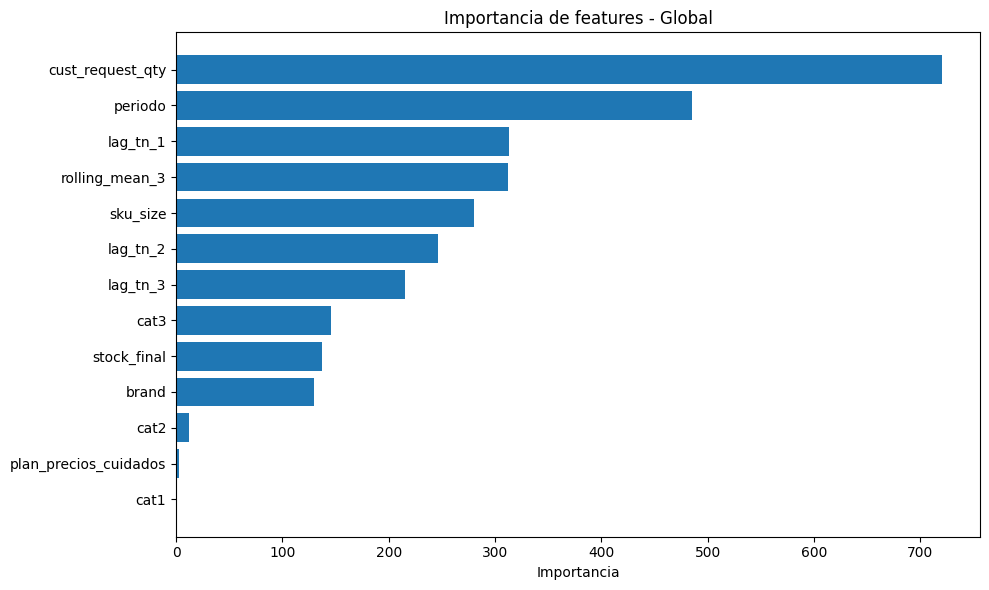

In [15]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import pandas as pd

# Extraer importancia de features
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importancia')
plt.title('Importancia de features - Global')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [16]:
# Asumimos que ya tenés df_all y df_productos registrados
con = duckdb.connect(database=':memory:')
con.register("df_all", df_all)
con.register("df_productos", df_productos)

# Paso 1: Crear tabla de lags para enero 2020
con.execute("""
    CREATE TABLE lags_202001 AS
    WITH base AS (
        SELECT
            product_id,
            MAX(CASE WHEN periodo = 201912 THEN tn END) AS lag_tn_1,
            MAX(CASE WHEN periodo = 201911 THEN tn END) AS lag_tn_2,
            MAX(CASE WHEN periodo = 201910 THEN tn END) AS lag_tn_3,
            AVG(CASE WHEN periodo IN (201910, 201911, 201912) THEN tn ELSE NULL END) AS rolling_mean_3
        FROM df_all
        WHERE periodo IN (201910, 201911, 201912)
        GROUP BY product_id
    )
    SELECT base.*, 202001 AS periodo FROM base
""")

# Paso 2: Tomar features estáticos desde df_productos
con.execute("""
    CREATE OR REPLACE TABLE static_features AS
    SELECT DISTINCT ON (product_id)
        product_id, cat1, cat2, cat3, brand, sku_size
    FROM df_productos
""")

# Paso 3: Agregar valores temporales desde diciembre 2019
con.execute("""
    CREATE TABLE temporal_features AS
    SELECT *
    FROM (
        SELECT 
            product_id,
            plan_precios_cuidados,
            cust_request_qty,
            stock_final,
            ROW_NUMBER() OVER (PARTITION BY product_id ORDER BY periodo DESC) as rn
        FROM df_all
        WHERE periodo = 201912
    ) 
    WHERE rn = 1
""")

# Paso 4: Unir todo para enero 2020
con.execute("""
    CREATE TABLE df_202001 AS
    SELECT 
        l.product_id,
        l.periodo,
        l.lag_tn_1, l.lag_tn_2, l.lag_tn_3, l.rolling_mean_3,
        s.cat1, s.cat2, s.cat3, s.brand, s.sku_size,
        t.plan_precios_cuidados,
        t.cust_request_qty,
        t.stock_final
    FROM lags_202001 l
    LEFT JOIN static_features s ON l.product_id = s.product_id
    LEFT JOIN temporal_features t ON l.product_id = t.product_id
""")

# Exportar a pandas para usar con el modelo
df_202001 = con.execute("SELECT * FROM df_202001").fetchdf()


In [17]:
# Verificamos que todas las columnas necesarias estén presentes
missing_cols = set(all_features) - set(df_202001.columns)
if missing_cols:
    print(f"⚠️ Faltan columnas en df_202001: {missing_cols}")
else:
    # Convertir columnas categóricas si es necesario
    categorical_cols = ['cat1', 'cat2', 'cat3', 'brand']
    for col in categorical_cols:
        if col in df_202001.columns:
            df_202001[col] = df_202001[col].astype('category')
    
    # Hacemos la predicción de tn
    df_202001['tn_pred'] = model.predict(df_202001[all_features])
    print("✅ Predicción de toneladas para enero 2020 completada.")


✅ Predicción de toneladas para enero 2020 completada.


In [18]:
# Registramos df_202001 con la predicción como tabla temporal
con.register("df_202001", df_202001)

# Paso 1: Crear tabla de lags para febrero 2020
con.execute("""
    CREATE OR REPLACE TABLE lags_202002 AS
    WITH base AS (
        SELECT
            p.product_id,
            p.tn_pred AS lag_tn_1,
            MAX(CASE WHEN a.periodo = 201912 THEN a.tn END) AS lag_tn_2,
            MAX(CASE WHEN a.periodo = 201911 THEN a.tn END) AS lag_tn_3,
            (p.tn_pred + 
             MAX(CASE WHEN a.periodo = 201912 THEN a.tn END) +
             MAX(CASE WHEN a.periodo = 201911 THEN a.tn END)) / 3.0 AS rolling_mean_3
        FROM df_202001 p
        LEFT JOIN df_all a ON p.product_id = a.product_id AND a.periodo IN (201911, 201912)
        GROUP BY p.product_id, p.tn_pred
    )
    SELECT base.*, 202002 AS periodo FROM base
""")

# Paso 2: Reutilizamos static_features y temporal_features desde diciembre 2019

# Paso 3: Construir dataset de predicción de febrero
con.execute("""
    CREATE OR REPLACE TABLE df_202002 AS
    SELECT 
        l.product_id,
        l.periodo,
        l.lag_tn_1, l.lag_tn_2, l.lag_tn_3, l.rolling_mean_3,
        s.cat1, s.cat2, s.cat3, s.brand, s.sku_size,
        t.plan_precios_cuidados,
        t.cust_request_qty,
        t.stock_final
    FROM lags_202002 l
    LEFT JOIN static_features s ON l.product_id = s.product_id
    LEFT JOIN temporal_features t ON l.product_id = t.product_id
""")

# Exportamos a pandas
df_202002 = con.execute("SELECT * FROM df_202002").fetchdf()

# Convertimos columnas categóricas
for col in categorical_cols:
    if col in df_202002.columns:
        df_202002[col] = df_202002[col].astype('category')

# Predecimos las toneladas para febrero 2020
df_202002['tn_pred'] = model.predict(df_202002[all_features])

print("✅ Predicción de toneladas para febrero 2020 completada.")


✅ Predicción de toneladas para febrero 2020 completada.


In [19]:
# Revisión rápida de duplicados en las tablas origen
print("🔍 Duplicados en static_features:")
print(con.execute("SELECT COUNT(*) - COUNT(DISTINCT product_id) FROM static_features").fetchone()[0])

print("🔍 Duplicados en temporal_features:")
print(con.execute("SELECT COUNT(*) - COUNT(DISTINCT product_id) FROM temporal_features").fetchone()[0])

print("🔍 Duplicados en lags_202002:")
print(con.execute("SELECT COUNT(*) - COUNT(DISTINCT product_id) FROM lags_202002").fetchone()[0])


🔍 Duplicados en static_features:
0
🔍 Duplicados en temporal_features:
0
🔍 Duplicados en lags_202002:
0


In [23]:
# Filtramos solo los productos presentes en df_to_predict
product_ids_to_predict = set(df_to_predict['product_id'])
df_kaggle = df_202002[df_202002['product_id'].isin(product_ids_to_predict)][['product_id', 'tn_pred']].copy()

# Renombramos columna para el formato requerido
df_kaggle.rename(columns={'tn_pred': 'tn'}, inplace=True)

# Guardamos como CSV
df_kaggle.to_csv('../data/kaggle_submission_feb2020.csv', index=False)

print("✅ Archivo 'kaggle_submission_feb2020.csv' generado con los productos requeridos.")
df_kaggle.shape[0]
#df_kaggle.head()

✅ Archivo 'kaggle_submission_feb2020.csv' generado con los productos requeridos.


780

In [22]:
import json

# Cargar y mostrar el contenido del archivo kaggle.json
try:
    with open("kaggle.json", "r") as f:
        creds = json.load(f)
        print("✅ Archivo kaggle.json leído correctamente.")
        print(f"👤 Usuario: {creds.get('username')}")
        print(f"🔑 API Key: {creds.get('key')[:4]}... (oculto por seguridad)")
except FileNotFoundError:
    print("❌ El archivo kaggle.json no se encuentra en el directorio actual.")
except json.JSONDecodeError:
    print("❌ El archivo kaggle.json no tiene un formato JSON válido.")
except Exception as e:
    print(f"❌ Error al leer kaggle.json: {e}")

❌ El archivo kaggle.json no se encuentra en el directorio actual.


In [ ]:
import subprocess

try:
    result = subprocess.run(
        [
            "kaggle", "competitions", "submit",
            "-c", "labo-iii-edicion-2025-v",
            "-f", "kaggle_submission_feb2020.csv",
            "-m", "Predicción febrero 2020"
        ],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        encoding="utf-8"  # cambia cp1252 (default en Windows) a utf-8
    )

    if result.returncode == 0:
        print("✅ Subida a Kaggle completada con éxito:")
        print(result.stdout)
    else:
        print("❌ Error al subir a Kaggle:")
        print(result.stderr)

except FileNotFoundError:
    print("❌ El comando 'kaggle' no se encontró. Verificá que esté instalado y en el PATH.")


# Pruebas de Feature Importance
Utilizando datos hasta Diciembre 2019 para probar ajuste del modelo

In [166]:
from sklearn.metrics import mean_absolute_error

# Simulamos predicción para diciembre
df_valid = df_all[df_all['periodo'] == 201912].copy()

# Entrenamos modelo solo con datos hasta noviembre
train_data = df_all[df_all['periodo'] < 201912].copy()

model_val = lgb.LGBMRegressor(random_state=42)
model_val.fit(train_data[all_features], train_data['tn'])

# Predecimos diciembre
df_valid['tn_pred'] = model_val.predict(df_valid[all_features])

# Calculamos error absoluto medio
mae = mean_absolute_error(df_valid['tn'], df_valid['tn_pred'])
print(f"📊 MAE validación diciembre 2019: {mae:.2f}")

# TFE (Total Forecast Error)
tfe = (df_valid['tn'] - df_valid['tn_pred']).abs().sum() / df_valid['tn'].sum()
print(f"📉 Total Forecast Error (TFE) diciembre 2019: {tfe:.4f}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 30131, number of used features: 13
[LightGBM] [Info] Start training from score 43.120861
📊 MAE validación diciembre 2019: 6.77
📉 Total Forecast Error (TFE) diciembre 2019: 0.2396


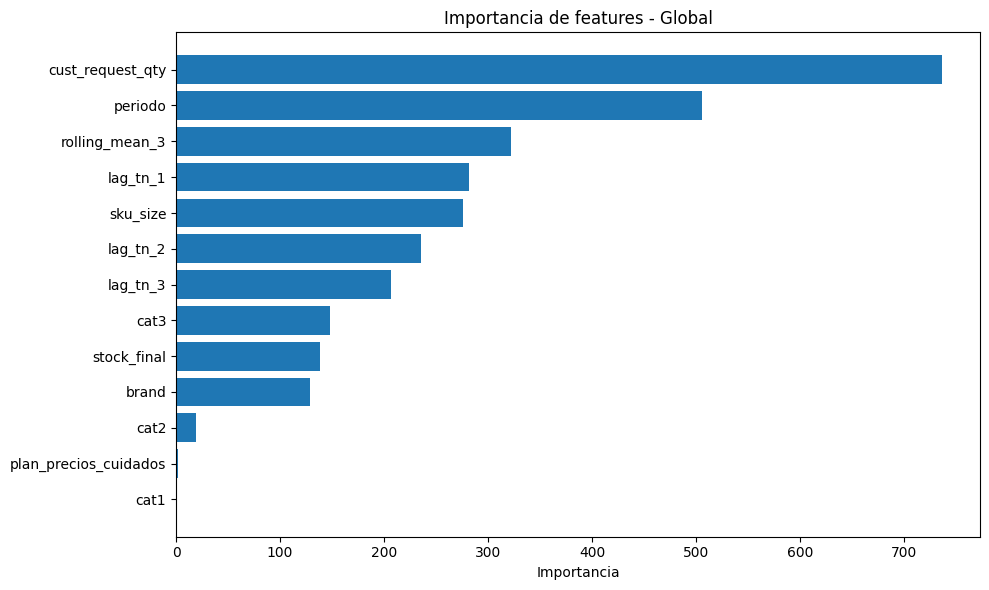

In [167]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import pandas as pd

# Extraer importancia de features
importance_df = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importancia')
plt.title('Importancia de features - Global')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


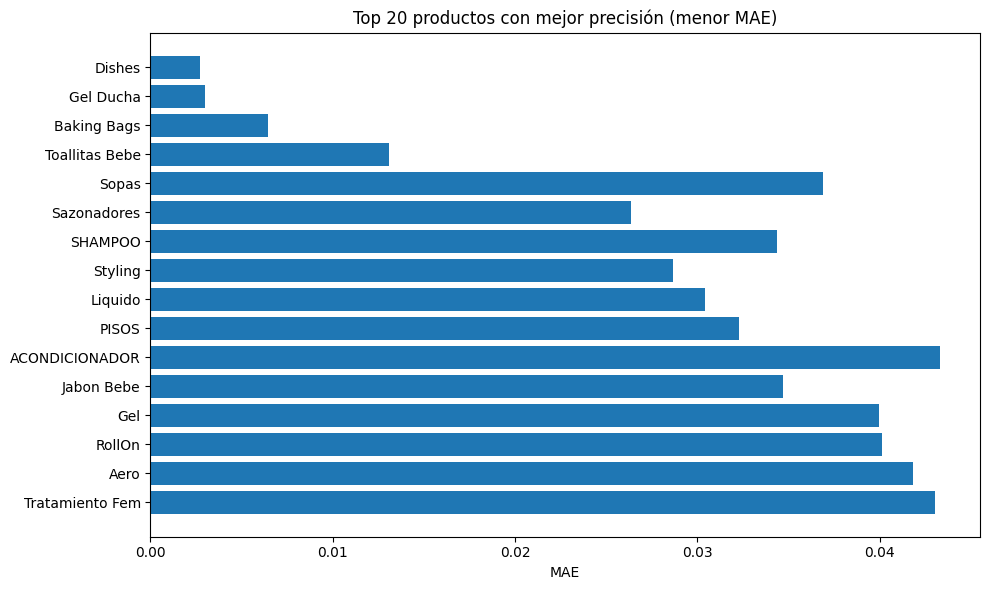

In [170]:
# Suponemos que df_productos tiene las columnas: 'product_id' y 'product_description'

# Calculamos el MAE por producto (ya debería estar calculado)
mae_por_producto = df_valid.groupby('product_id').apply(
    lambda df: mean_absolute_error(df['tn'], df['tn_pred'])
).reset_index(name='mae')

# Unimos con los nombres de producto
mae_con_nombres = mae_por_producto.merge(
    df_productos[['product_id', 'cat3']],
    on='product_id',
    how='left'
)

# Elegimos los 20 productos con menor MAE
top20 = mae_con_nombres.sort_values('mae').head(20)

# Graficamos
plt.figure(figsize=(10, 6))
plt.barh(top20['cat3'], top20['mae'])
plt.xlabel('MAE')
plt.title('Top 20 productos con mejor precisión (menor MAE)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
